In [1]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import community as community_louvain
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import json
import os

import pickle

In [2]:
# Load graph object from pickle file that we saved in lecture 4
DIRECTED_G = pickle.load(open('../data/graph.pickle', 'rb'))
UNDIRECTED_G = DIRECTED_G.copy().to_undirected()

In [3]:
def plot_network(graph):
    # Assigning a color to each community for visualization
    # community_colors = cm.rainbow(np.linspace(0, 1, len(communities)))

    # Create a dictionary to assign a color to each node based on its community
    # node_colors = {}
    # for community_index, community_nodes in enumerate(communities):
    #     for node in community_nodes:
    #         node_colors[node] = community_colors[community_index]


    # Visualize the graph with community colors
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)  # or use other layout algorithms like nx.kamada_kawai_layout
    nx.draw(graph, pos, 
            # node_color=[node_colors[node] for node in graph.nodes()], 
            edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)
    plt.show()

# Community Detection

In [4]:
print(f"Size of graph BEFORE pruning - nodes: {UNDIRECTED_G.number_of_nodes()} & edges: {UNDIRECTED_G.number_of_edges()}")
UNDIRECTED_G = UNDIRECTED_G.subgraph(max(nx.connected_components(UNDIRECTED_G), key=len))
print(f"Size of graph AFTER pruning - nodes: {UNDIRECTED_G.number_of_nodes()} & edges: {UNDIRECTED_G.number_of_edges()}")

Size of graph BEFORE pruning - nodes: 18823 & edges: 29528
Size of graph AFTER pruning - nodes: 12687 & edges: 28259


## Louvain

In [5]:
def others_communities(communities, others):
    new_community = set()
    for j in others:
        new_community = new_community.union(communities[j])

    return [comm for i, comm in enumerate(communities) if i not in others] + [new_community]

In [6]:
df = pd.DataFrame(columns=["Resolution", "# Communities", "# Significant Communities", "Communities", "Node distribution", "Node distribution (%)", "Others (%)",
                           "Communities (with Others)","Initial modularity", "'Others' modularity"])

for i in range(10):
    # Apply the Louvain community detection algorithm
    resolution = 0 + (i*2)*0.1
    communities = louvain_communities(UNDIRECTED_G, resolution=resolution, seed=1234)
    communities = sorted([comm for comm in communities], key=len, reverse=True)
    len_communities = [len(comm) for comm in communities]
    percentages = [100*l/sum(len_communities) for l in len_communities]
    others = [i for i, el in enumerate(percentages) if el < 1]
    communities_others = others_communities(communities,  others)
    df.loc[len(df)] = {
        "Resolution": resolution,
        "# Communities": len(communities),
        "# Significant Communities": len([l/sum(percentages) for l in percentages if l > 1]),
        "Communities": communities,
        "Node distribution": len_communities,
        "Node distribution (%)": percentages,
        "Others (%)": sum([el for i, el in enumerate(percentages) if i in others]),
        "Communities (with Others)": communities_others,
        "Initial modularity": nx.community.modularity(UNDIRECTED_G, communities),
        "'Others' modularity": nx.community.modularity(UNDIRECTED_G, communities_others)
    }

In [7]:
df

,Resolution,# Communities,# Significant Communities,Communities,Node distribution,Node distribution (%),Others (%),Communities (with Others),Initial modularity,'Others' modularity
0,0.0,1,1,"[{FIFA Street 2, Mighty Switch Force!, Giga Wi...",[12687],[100.0],0.000000,"[{FIFA Street 2, Mighty Switch Force!, Giga Wi...",0.000000,0.000000
1,0.2,20,6,"[{Crysis 3, Fallout: New Vegas, Full Spectrum ...","[4024, 3599, 3245, 814, 382, 168, 119, 64, 56,...","[31.71750610861512, 28.367620398833452, 25.577...",3.586348,"[{Crysis 3, Fallout: New Vegas, Full Spectrum ...",0.636439,0.635795
2,0.4,25,13,"[{Crysis 3, Teslagrad 2, Full Spectrum Warrior...","[2466, 1931, 1728, 1579, 1096, 828, 820, 621, ...","[19.43721920075668, 15.220304248443288, 13.620...",4.130212,"[{Crysis 3, Teslagrad 2, Full Spectrum Warrior...",0.738120,0.737454
3,0.6,33,20,"[{Crysis 3, Damage Incorporated, Retro/Grade, ...","[1418, 1263, 956, 896, 857, 816, 759, 756, 667...","[11.176795144636241, 9.955072121068811, 7.5352...",4.059273,"[{Crysis 3, Damage Incorporated, Retro/Grade, ...",0.763721,0.762962
4,0.8,42,26,"[{Tetris Worlds, Donkey Kong Country Returns, ...","[1146, 1038, 876, 828, 671, 660, 659, 630, 609...","[9.032868290375976, 8.18160321589028, 6.904705...",6.368724,"[{Tetris Worlds, Donkey Kong Country Returns, ...",0.767113,0.765329
5,1.0,50,33,"[{Tetris Worlds, Donkey Kong Country Returns, ...","[1015, 713, 684, 639, 629, 603, 598, 586, 571,...","[8.000315283360921, 5.619925908410184, 5.39134...",5.832742,"[{Tetris Worlds, Donkey Kong Country Returns, ...",0.768167,0.766572
6,1.2,57,37,"[{Croc 2, All Star Tennis '99, Donkey Kong Cou...","[848, 660, 564, 545, 507, 499, 494, 428, 426, ...","[6.6840072515173015, 5.2021754551903525, 4.445...",6.951998,"[{Croc 2, All Star Tennis '99, Donkey Kong Cou...",0.765729,0.763421
7,1.4,74,32,"[{Donkey Kong Country Returns, Croc 2, All Sta...","[828, 629, 565, 546, 534, 523, 515, 481, 452, ...","[6.526365571056988, 4.957830850476866, 4.45337...",15.638055,"[{Donkey Kong Country Returns, Croc 2, All Sta...",0.766013,0.753492
8,1.6,78,30,"[{Tetris Worlds, Donkey Kong Country Returns, ...","[870, 654, 513, 511, 498, 493, 481, 469, 377, ...","[6.8574131000236465, 5.154882951052258, 4.0435...",23.236384,"[{Tetris Worlds, Donkey Kong Country Returns, ...",0.764925,0.733721
9,1.8,86,36,"[{Donkey Kong Country Returns, Croc 2, All Sta...","[774, 576, 489, 448, 447, 439, 380, 369, 360, ...","[6.100733033814141, 4.540080397257035, 3.85433...",22.479704,"[{Donkey Kong Country Returns, Croc 2, All Sta...",0.764597,0.738211


In [8]:
def to_percentage(l):
    return [100*el/sum(l) for el in l]

[11.176795144636241, 9.955072121068811, 7.535272326002995, 7.062347284622054, 6.754946007724443, 6.4317805627808, 5.982501773468905, 5.958855521399858, 5.257350043351462, 5.162765035075274, 4.800189170016552, 4.067155355876094, 3.85433908725467, 3.1922440293213525, 2.254276030582486, 1.9232285016158273, 1.276897611728541, 1.1665484354063214, 1.1034917632221959, 1.024670922992039, 0.7960904863245842, 0.7724442342555372, 0.4965712934499882, 0.45716087333490973, 0.3783400331047529, 0.24434460471348624, 0.23646252069047055, 0.14975959643729803, 0.14187751241428234, 0.11034917632221959, 0.10246709229920391, 0.10246709229920391, 0.07093875620714117]


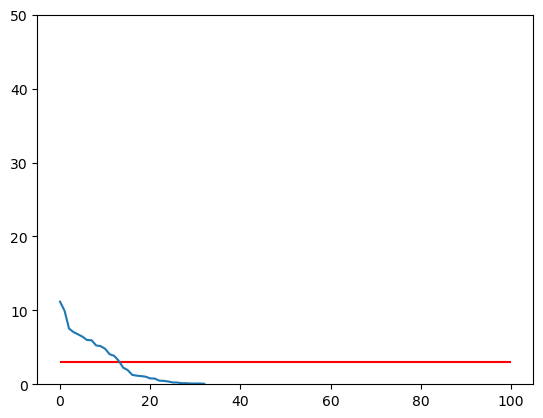

In [21]:
to_plot = df["Node distribution (%)"].iloc[3]
print(to_plot)
plt.hlines([np.average(to_plot)],[0],[100], colors=['red'])
plt.ylim(0,50)
plt.plot(range(len(to_plot)), to_plot)
plt.show()

In [10]:
print(f"Modularity: {nx.community.modularity(UNDIRECTED_G, communities)}")

Modularity: 0.7645968029989302


## Spectral Clustering

In [16]:
from sklearn.cluster import SpectralClustering
def spectral_clustering(graph, n_clusters = 10):
    # Convert the graph into an adjacency matrix
    adj_matrix = nx.to_numpy_array(graph)

    # Perform spectral clustering
    # In practice, this should be based on the specific characteristics of the graph.
    spectral_cluster = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral_cluster.fit_predict(adj_matrix)

    # Output the labels to see the community assignments
    return labels.tolist()

In [17]:
import collections
labels = spectral_clustering(UNDIRECTED_G, 10)
collections.Counter(labels)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\PC-312\.conda\envs\sg_i\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\PC-312\.conda\envs\

Counter({0: 12538,
         7: 17,
         3: 10,
         8: 63,
         6: 10,
         2: 9,
         4: 7,
         1: 11,
         5: 11,
         9: 11})

# Get Community Information

In [11]:
chosen = 3
communities = df["Communities (with Others)"].iloc[chosen]

In [12]:
# Others
communities[-1]

{'1942: The Pacific Air War',
 '2nd Super Robot Wars',
 '2nd Super Robot Wars OG',
 '3D Monster Maze',
 '3D Tunnel',
 '3rd Super Robot Wars',
 '4th Super Robot Wars',
 "A Witch's Tale",
 'ABBA: You Can Dance',
 'AaAaAA!!! – A Reckless Disregard for Gravity',
 'Aces of the Deep',
 'Aces of the Pacific',
 'Aedis Eclipse: Generation of Chaos',
 'Africa Trail',
 'Aikatsu Friends!',
 'Aikatsu Planet!',
 'Aikatsu Stars!',
 'Aikatsu on Parade!',
 'Aikatsu!',
 'Aliens vs. Predator: Requiem (video game)',
 'Alternate Reality: The City',
 'Alternate Reality: The Dungeon',
 'Amazon Trail 3rd Edition',
 'Amazon Trail II',
 "Another Century's Episode",
 "Another Century's Episode 2",
 "Another Century's Episode 3: The Final",
 "Another Century's Episode Portable",
 "Another Century's Episode: R",
 'Ant War',
 'Ar Tonelico: Melody of Elemia',
 'Armor Command',
 'Artillery Duel',
 'Asphalt 3D',
 'Asphalt 4: Elite Racing',
 'Asphalt 5',
 'Asphalt 6: Adrenaline',
 'Asphalt 7: Heat',
 'Asphalt 8: Airbor

In [33]:
def get_community_violence(community):
    nodes_in_community = (node for node in UNDIRECTED_G if node in community)
    sentiments = nx.get_node_attributes(UNDIRECTED_G, "sentiment")

    return [sentiments[node]['violence'] for node in nodes_in_community if node in sentiments]

In [14]:
attributes = ['outpages', 'year', 'country of development', 'sentiment', 'genres']

In [15]:
from collections import Counter
def community_genre_analysis(community):
    nodes_in_community = [node for node in UNDIRECTED_G if node in community]
    genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
    nodes_in_genre = [node for node in nodes_in_community if node in genres.keys()]
    flatten_genres = [g  for node in nodes_in_genre for g in genres[node]]
    counts = dict(Counter(flatten_genres))
    total = sum(counts.values())
    # total = len(nodes_in_genre)
    counts = sorted(counts.items(), key=lambda k: k[1], reverse=True)
    counts = [(i, 100*c/total) for i,c in counts]
    return counts

In [16]:
def get_in_degree(community):
    return [DIRECTED_G.in_degree(node) for node in community]
def get_out_degree(community):
    return [DIRECTED_G.out_degree(node) for node in community]
def get_degree(community):
    return [UNDIRECTED_G.degree(node) for node in community]

In [34]:
years = nx.get_node_attributes(UNDIRECTED_G, "year")

info = dict()
info["sentiment"] = {i: np.average(get_community_violence(comm)) for i,comm in enumerate(communities)}
info["sentiment_more"] = {i: get_community_violence(comm) for i,comm in enumerate(communities)}
info["year"] = {i: np.average([years[el] for el in comm if el in years]) for i,comm in enumerate(communities)}
info["year_more"] = {i: [years[el] for el in comm if el in years] for i,comm in enumerate(communities)}
info["genre"] = {i: community_genre_analysis(comm)  for i,comm in enumerate(communities)}
info["in_degree"] = {i: get_in_degree(comm)  for i,comm in enumerate(communities)}
info["out_degree"] = {i: get_out_degree(comm)  for i,comm in enumerate(communities)}

In [18]:
sorted_communities_by_year_indexes = [str(i) for i,_ in sorted(list(info["year"].items()), key=lambda x: x[1])]

In [26]:
def boxplot_communities(y,x, title, yscale = None):
    fig, ax = plt.subplots(figsize=(10,6))
    # Create a boxplot
    ax.boxplot(y, labels=x)

    # Add titles and labels
    ax.set_title(title)
    ax.set_ylabel('Values')
    ax.set_xlabel('Categories')
    if yscale != None:
        ax.set_yscale('log')
    # Show the plot
    fig.show()

C:\Users\PC-312\AppData\Local\Temp\ipykernel_23152\2245855642.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


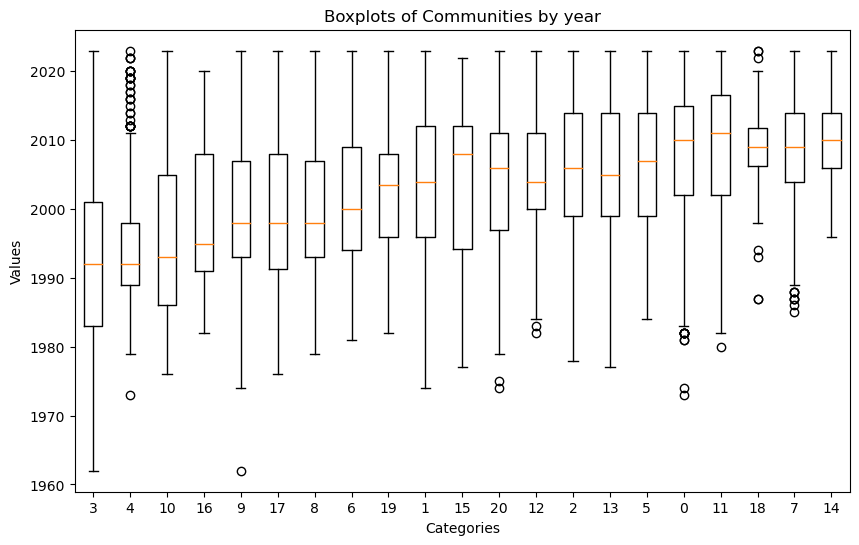

In [27]:
import matplotlib.pyplot as plt

# Prepare figure
# You can adjust the size as needed
y = [info["year_more"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by year')

C:\Users\PC-312\AppData\Local\Temp\ipykernel_23152\2245855642.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


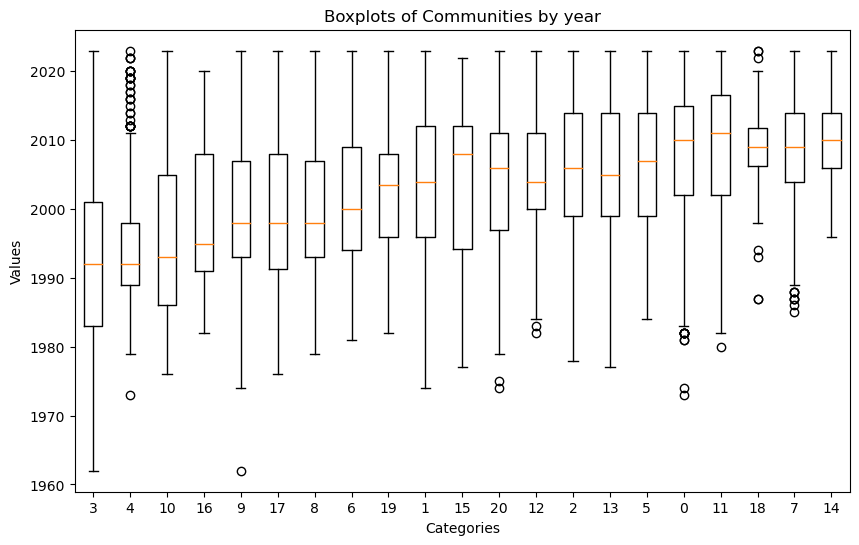

In [35]:
import matplotlib.pyplot as plt

# Prepare figure
# You can adjust the size as needed
y = [info["year_more"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by year')

C:\Users\PC-312\AppData\Local\Temp\ipykernel_23152\2245855642.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


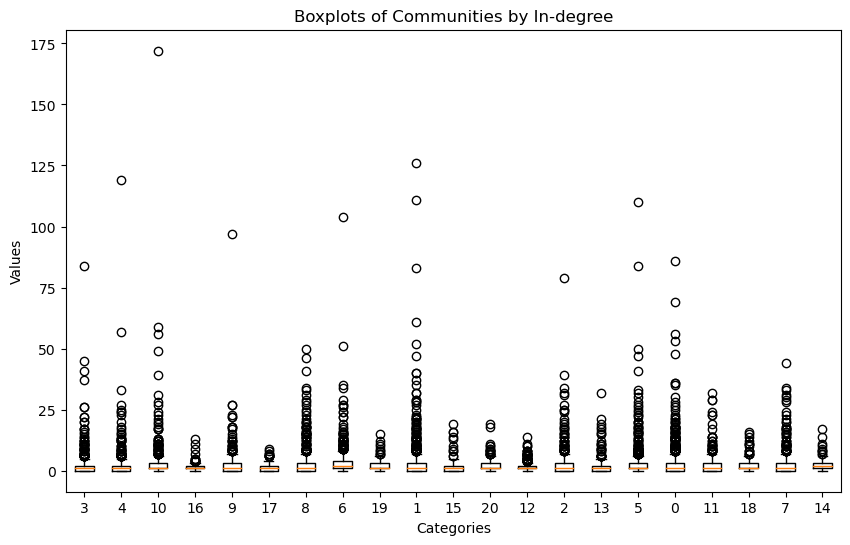

In [29]:
import math

y = [[d for d in info["in_degree"][int(i)]] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by In-degree')

In [93]:
from scipy import stats
def kruskal_wallis_test(*groups):
    """
    Perform the Kruskal-Wallis H Test
    :param groups: Variable number of lists, each representing a community's node degrees
    :return: Kruskal-Wallis H test result
    """
    stat, p_value = stats.kruskal(*groups)
    return stat, p_value

iter_list = [int(i) for i in sorted_communities_by_year_indexes]
results = pd.DataFrame(columns=['index'] + iter_list)
threshold = 0.05
for k, i in enumerate(iter_list):
    iteration = dict()
    iteration["index"] = i
    # for j in iter_list[0: (k+1)]:
    #     iteration[j] = "-"
    for j in iter_list[(k+1):len(iter_list)]:
        (stat, p_value) = kruskal_wallis_test(info['in_degree'][i], info['in_degree'][j])
        iteration[j] = "+" if p_value < threshold else " "
    results.loc[len(results)] = iteration

In [94]:
results

,index,3,4,10,16,9,17,8,6,19,...,20,12,2,13,5,0,11,18,7,14
0,3,NaN,+,+,,,,+,+,+,...,+,+,+,+,+,+,+,+,+,+
1,4,NaN,NaN,+,,,,+,+,+,...,,+,,,+,,,,+,+
2,10,NaN,NaN,NaN,+,+,+,,,,...,,,+,+,,+,,,,
3,16,NaN,NaN,NaN,NaN,,,+,+,+,...,,+,,,+,,,+,+,+
4,9,NaN,NaN,NaN,NaN,NaN,,+,+,+,...,,+,,,+,,+,+,+,+
5,17,NaN,NaN,NaN,NaN,NaN,NaN,+,+,+,...,+,+,+,+,+,,+,+,+,+
6,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,...,,,+,+,,+,,,,
7,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,...,+,+,+,+,,+,+,,+,
8,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,,,,
9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,+,+,,+,,,,


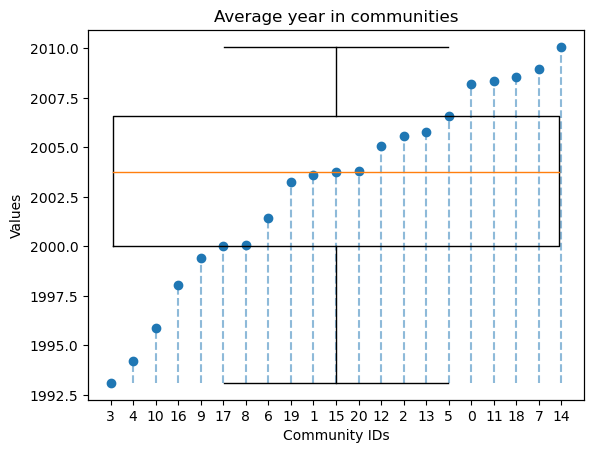

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Scatter plot
y = [info["year"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
ax1.scatter(x, y)

# Set the x-ticks to correspond to the scatter plot
ax1.set_xticks(x)
ax1.set_xticklabels(x)

# Adding titles and labels
ax1.set_title('Average year in communities')
ax1.set_ylabel('Values')
ax1.set_xlabel('Community IDs')

# Creating secondary x-axis for scatter plot
ax2 = ax1.twiny()

# Creating the boxplot
box_width = 0.9
ax2.boxplot(y, widths=box_width)

# Hide the original x-axis
ax2.set_xticks([])

# Drawing vertical, discontinuous lines from x-axis to each scatter point
for x_val, y_val in zip(x, y):
    ax1.vlines(x_val, ymin=min(y), ymax=y_val, linestyles='dashed', alpha=0.5)

plt.show()

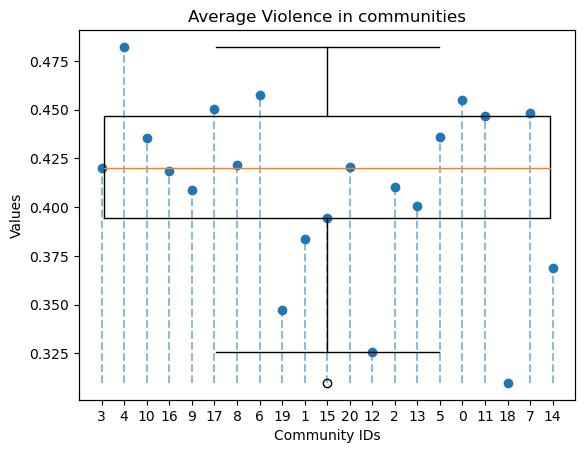

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Scatter plot
y = [info["sentiment"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
ax1.scatter(x, y)

# Set the x-ticks to correspond to the scatter plot
ax1.set_xticks(x)
ax1.set_xticklabels(x)

# Adding titles and labels
ax1.set_title('Average Violence in communities')
ax1.set_ylabel('Values')
ax1.set_xlabel('Community IDs')

# Creating secondary x-axis for scatter plot
ax2 = ax1.twiny()

# Creating the boxplot
box_width = 0.9
ax2.boxplot(y, widths=box_width)

# Hide the original x-axis
ax2.set_xticks([])

# Drawing vertical, discontinuous lines from x-axis to each scatter point
for x_val, y_val in zip(x, y):
    ax1.vlines(x_val, ymin=min(y), ymax=y_val, linestyles='dashed', alpha=0.5)

plt.show()

In [ ]:
def genre_analysis():
    genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
    nodes_in_genre = [node for node in UNDIRECTED_G if node in genres.keys()]
    flatten_genres = [g  for node in nodes_in_genre for g in genres[node]]
    counts = dict(Counter(flatten_genres))
    # total = sum(counts.values())
    total = len(nodes_in_genre)
    counts = sorted(counts.items(), key=lambda k: k[1], reverse=True)
    counts = [(i, 100*c/total) for i,c in counts]
    return counts, len(nodes_in_genre)
overall_prop, total_games_with_genre = genre_analysis()

In [ ]:
from scipy.stats import chi2_contingency

def check_significant_overrepresentation(overall_proportions, community_proportions, total_games):
    significant_genres = []
    # total_games_in_community = sum(c for _,c in overall_proportions)
    for genre, comm_prop in community_proportions:
        overall_prop = next((item[1] for item in overall_proportions if item[0] == genre), None)
        if overall_prop is None:
            continue  # Skip if genre is not found in overall proportions

        # Calculate expected and observed counts
        expected_count = overall_prop * total_games / 100
        observed_count = comm_prop * total_games / 100
        contingency_table = np.array([[observed_count, total_games - observed_count],
                                      [expected_count, total_games - expected_count]])

        # Perform the chi-squared test
        chi2, p_value = chi2_contingency(contingency_table)[:2]

        if p_value < 0.05:  # Consider significance level of 0.05
            if observed_count > expected_count:
                representation = '+++ Overrepresented +++'
            else:
                representation = '--- Underrepresented ---'
            significant_genres.append((genre, comm_prop, 100*(observed_count/expected_count-1), representation))

    return sorted(significant_genres, key=lambda x: x[2], reverse=True)

In [ ]:
genre_breakdown = pd.DataFrame(columns=["Community", "Genre", "Presence (%)", "Increase (%)", "Status"])
genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
max_genre_length = max(len(g) for g in genres)
total = 0
for i in range(len(communities)):
    print(f"Community {i}:")
    significant_genres = check_significant_overrepresentation(overall_prop, info['genre'][i], total_games_with_genre)
    print(f"\tMain genres:")
    for (g,c,v,r) in significant_genres:
        print(f"\t\t{g.ljust(max_genre_length)}{round(c,2)}%\t{round(v,2)}%\t{r}")
        total += c
        genre_breakdown.loc[len(genre_breakdown)] = {
            "Community": i,
            "Genre": g, 
            "Presence (%)": round(c,2),
            "Increase (%)": round(v,2),
            "Status": r
        }
    

Community 0:
	Main genres:
		Social deduction video games                                                                 0.33%	1085.51%	+++ Overrepresented +++
		Survival horror video games                                                                  1.78%	898.32%	+++ Overrepresented +++
		Immersive sims                                                                               2.79%	887.92%	+++ Overrepresented +++
		Battle royale games                                                                          2.79%	771.7%	+++ Overrepresented +++
		Sandbox games                                                                                0.67%	611.3%	+++ Overrepresented +++
		Stealth video games                                                                          10.93%	453.24%	+++ Overrepresented +++
		Psychological horror games                                                                   3.23%	370.95%	+++ Overrepresented +++
		Survival video games                    

In [ ]:
genre_breakdown

,Community,Genre,Presence (%),Increase (%),Status
0,0,Social deduction video games,0.33,1085.51,+++ Overrepresented +++
1,0,Survival horror video games,1.78,898.32,+++ Overrepresented +++
2,0,Immersive sims,2.79,887.92,+++ Overrepresented +++
3,0,Battle royale games,2.79,771.70,+++ Overrepresented +++
4,0,Sandbox games,0.67,611.30,+++ Overrepresented +++
...,...,...,...,...,...
422,20,Roguelike video games,0.69,-28.30,--- Underrepresented ---
423,20,Fighting games,2.08,-38.12,--- Underrepresented ---
424,20,Metroidvania games,0.35,-73.44,--- Underrepresented ---
425,20,Adventure games,1.04,-77.89,--- Underrepresented ---


In [ ]:
genre_breakdown.to_csv('genre_breakdown.csv', index=False)

### Community 0
- **Overrepresented Genres:** Social deduction video games, Survival horror video games, Immersive sims, Battle royale games, Sandbox games, Stealth video games, Psychological horror games, Survival video games, Horror video games, Open-world video games, Construction and management simulation games, Art games, Shooter games, Interactive movie video games, Neo-noir video games, Sports video games, Action-adventure games, Simulation video games, Strategy video games, Adventure games, Puzzle video games.
    - This community shows a strong preference for interactive and immersive gaming experiences, with genres like Social deduction, Survival horror, and Immersive sims.

### Community 1
- **Overrepresented Genres:** Aviation video games, Dress-up video games, Vehicle-building video games, Party video games, Pinball video games, Educational video games, Digital tabletop games, Puzzle video games, Shooter games, Metroidvania games, Platformers, Racing video games, Action-adventure games, Construction and management simulation games, Art games, Simulation video games, Tactical role-playing video games, Action games, Horror video games, Hack and slash games, Open-world video games.
    - This community has a diverse range of interests, from the simulation aspects of Aviation and Vehicle simulation games to creative elements in Dress-up and educational games.

### Community 2
- **Overrepresented Genres:** Pinball video games, Role-playing video games, Strategy video games, Simulation video games, Tactical role-playing video games, Open-world video games, Roguelike video games, Survival video games, Construction and management simulation games, Hack and slash games.
    - Preferences in this community range from traditional arcade-style gaming (Pinball) to immersive, character-driven experiences in RPGs and MMOs.

### Community 3
- **Overrepresented Genres:** Non-games, Quiz video games, Shooter games, Digital tabletop games, Martial arts video games, Typing video games, Educational video games, Racing video games, Action games, Pinball video games, Beat 'em ups, Sandbox games, Platformers, Strategy video games, Fighting games, Puzzle video games, Action-adventure games.
    - This community values a mix of casual, knowledge-based, and action-oriented gaming experiences, ranging from casual word and quiz games to intense shooter games.

### Community 4
- **Overrepresented Genres:** Sports video games, Puzzle video games, Platformers, Beat 'em ups, Horror video games, Action games, Metroidvania games, Eroge, Hack and slash games, Interactive movie video games, Fighting games, Shooter games, Racing video games.
    - A preference for physical simulation games (like Sports and Racing) and mental challenges (like Puzzles and Platform games) is evident in this community.

### Community 5
- **Overrepresented Genres:** Incremental games, Metroidvania games, Strategy video games, Interactive movie video games, Horror video games, Action games, Puzzle video games, Construction and management simulation games, Role-playing video games, Racing video games, Party video games, and Action-adventure games.
    - This community shows a liking for both slow, steady progress in Incremental games and exploration-based, complex experiences in Metroidvania games.

### Community 6
- **Overrepresented Genres:** Music video games, Digital tabletop games, Non-games, Puzzle video games, Educational video games, Shooter games, Quiz video games, Interactive movie video games, Sandbox games, Racing video games, Action games, Hack and slash games, and Action-adventure games.
    - Indicates a diverse range of interests from musical rhythm to intellectual puzzles and action-oriented games.

### Community 7
- **Overrepresented Genres:** Incremental games, Interactive movie video games, Construction and management simulation games, Metroidvania games, Puzzle video games, Strategy video games, Horror video games, Action games, Shooter games, Racing video games, Fighting games, and Action-adventure games.
    - Appreciation for strategic planning and narrative-driven gameplay is evident in this community.

### Community 8
- **Overrepresented Genres:** Educational video games, Digital tabletop games, Puzzle video games, Shooter games, Racing video games, Beat 'em ups, Interactive movie video games, Fighting games, Action games, Role-playing video games, Sports video games, Platformers, Strategy video games, and Horror video games.
    - A community with broad gaming tastes, from educational and strategy games to physically engaging genres like Racing and Beat 'em ups.

### Community 9
- **Overrepresented Genres:** Digital tabletop games, Puzzle video games, Music video games, Shooter games, Interactive movie video games, Racing video games, Beat 'em ups, Horror video games, Platformers, Fighting games, Action games, Role-playing video games, and Action-adventure games.
    - Balances intellectual challenge, rhythm-based gameplay, and action-oriented experiences.

### Community 10
- **Overrepresented Genres:** Music video games, Digital tabletop games, Non-games, Puzzle video games, Educational video games, Shooter games, Racing video games, Interactive movie video games, Sandbox games, Beat 'em ups, Action games, Platformers, Strategy video games, Fighting games, Role-playing video games, and Action-adventure games.
    - Eclectic tastes, enjoying everything from music and puzzle games to dynamic genres like Racing and Beat 'em ups.

### Community 11
- **Overrepresented Genres:** Incremental games, Puzzle video games, Interactive movie video games, Sandbox games, Racing video games, Beat 'em ups, Action games, Strategy video games, Horror video games, Fighting games, Role-playing video games, and Action-adventure games.
    - A preference for creative freedom and intense gameplay experiences, with a mix of Incremental, Sandbox, and Horror genres.

### Community 12
- **Overrepresented Genres:** Music video games, Puzzle video games, Educational video games, Interactive movie video games, Racing video games, Shooter games, Horror video games, Beat 'em ups, Action games, Platformers, Fighting games, Role-playing video games, and Action-adventure games.
    - Appreciation for a mix of educational content, musical rhythm, and a variety of action-oriented games.

### Community 13
- **Overrepresented Genres:** Music video games, Puzzle video games, Interactive movie video games, Racing video games, Shooter games, Horror video games, Beat 'em ups, Action games, Platformers, Strategy video games, Fighting games, Role-playing video games, and Action-adventure games.
    - Diverse gaming interests, from Music and Puzzle games to action genres like Racing and Shooter games.

### Community 14
- **Overrepresented Genres:** Eroge, Music video games, Construction and management simulation games, Mystery video games, Fighting games, Tactical role-playing video games, Shooter games, Party video games, Hack and slash games, and Role-playing video games.
    - Unique and varied tastes in gaming, from adult-themed Eroge and rhythm-based Music games to Construction and management simulation games.

### Community 15
- **Overrepresented Genres:** Incremental games, Puzzle video games, Metroidvania games, Platformers, Strategy video games, Action games, Simulation video games, Interactive movie video games, Horror video games, and Open-world video games.
    - Enjoys games that offer both strategic challenges and narrative-driven experiences, with a mix of Incremental, Metroidvania, and Strategy games.

### Community 16
- **Overrepresented Genres:** Educational video games, Interactive movie video games, Construction and management simulation games, Racing video games, Pinball video games, Shooter games, Puzzle video games, Horror video games, Party video games, Action-adventure games, Stealth video games, Art games, Platformers, Fighting games, Beat 'em ups, and Action games.
    - Shows a diverse range of interests from educational and interactive experiences to dynamic genres like Racing and Fighting games.

### Community 17
- **Overrepresented Genres:** Interactive movie video games, Strategy video games, Battle royale games, Racing video games, Horror video games, Beat 'em ups, Simulation video games, Survival video games, Party video games, Action games, Platformers, and Fighting games.
    - Values both strategic thinking and high-energy gameplay, with a preference for Interactive movie and Strategy games alongside dynamic genres like Battle Royale and Racing.

### Community 18
- **Overrepresented Genres:** Music video games, Eroge, Party video games, and Hack and slash games.
    - Distinct preference for rhythm-based games, adult-themed Eroge, and high-action Hack and slash games.

### Community 19
- **Overrepresented Genres:** Non-games, Sandbox games, Construction and management simulation games, Stealth video games, Survival video games, Simulation video games, Psychological horror games, Adventure games, Open-world video games, Tactical role-playing video games, Strategy video games, Fighting games, and Action games.
    - Preference for immersive, open-ended gaming experiences, with a mix of Sandbox, Stealth, and Psychological horror games.

### Community 20 - Others
- **Overrepresented Genres:** Quiz video games, Music video games, Digital tabletop games, Typing video games, Tactical role-playing video games, Educational video games, Action games, Sports video games, Party video games, Survival horror video games, Neo-noir video games, Action-adventure games, Role-playing video games, Beat 'em ups, Hack and slash games, and Survival video games.
    - Enjoys a wide range of genres from intellectual and music-based games to physically engaging and action-packed experiences.
